# A fastai/Pytorch implementation of MixMatch

In this post, I will be discussing and implementing "MixMatch: A Holistic Approach to Semi-Supervised Learning", by Berthelot, Carlini, Goodfellow, Oliver, Papernot and Raffel [1]. Released in May 2019, MixMatch is a semi-supervised learning algorithm which has significantly outperformed previous approaches. This blog comes from discussions had within Dr. Ehsan Kamalinejad's machine learning research group at Cal State East Bay.

How much of an improvement is MixMatch? When trained on CIFAR10 with 250 labeled images, MixMatch outperforms the next best technique (Virtual Adversarial Training) by almost 25% on the error rate (11.08% vs 36.03%, for comparison the fully supervised case on all 50k images has an error rate of 4.13%). These are far from incremental results, and the technique shows the potential to dramatically improve the state of semi-supervised learning. 

Semi-supervised learning is largely a battle against overfitting; when the labeled set is small it doesn't take a very large neural network to memorize the entire training set. The general idea behind nearly all semi-supervised approaches is to leverage unlabeled data as a regularizer on the training of labeled data. For a great overview of various semi-supervised learning methods, see [this blog by Sebastian Ruder](http://ruder.io/semi-supervised/). Different techniques employ different forms of regularization, and the MixMatch paper divides these into three groups: entropy minimization, consistency regularization, and generic regularization. As all three forms of regularization have proved effective, the MixMatch algorithm contains features from each.

MixMatch is a combination and improvement upon several of these techniques that have come out in recent years, including: Mean Teacher [2], Virtual Adversarial Training [3], and Mixup [4]. At a high level, the idea of MixMatch is to label the unlabeled data using predictions from the model and then apply heavy regularization in several forms. The first is performing data augmentation several times and taking the average for the label prediction. These predictions are then 'sharpened' to reduce their entropy. Finally, Mixup is performed on the labeled and unlabeled sets.

I am aiming this post at those familiar with Pytorch, but not necessarily fastai. For a Jupyter notebook version of this post containing the full code needed to reproduce all the results see [this repository](https://github.com/noachr/MixMatch-fastai).

### fastai
Before diving into the paper, I'll briefly talk about fastai. Fastai is a library, built on Pytorch, which makes writing machine learning applications much easier and simpler. They also offer a [terrific online course](https://course.fast.ai/) covering both fastai and deep learning in general. Compared to pure Pytorch, fastai dramatically reduces the amount of boilerplate code required to produce state of the art neural networks. Here we'll be using the data pipeline and training loop features of fastai. 

In [1]:
#Importing fastai will also import numpy, pytorch, etc. 
from fastai.vision import *
from numbers import Integral
import seaborn as sns

### Components
Let's first describe the individual pieces needed to assemble MixMatch, and then at the end put them together to form the complete algorithm. Following the paper, we'll be using CIFAR10 and taking 500 randomly selected images as the labeled training set. The standard 10000 image test set is used for all accuracy measurements.  

#### Data Augmentation 
Data augmention is a widely used consistency regularization technique, with it's biggest success (so far) found in the computer vision realm. The idea is to alter the input data while preserving its semantic label. For images, common augmentations include rotation, cropping, zooming, brightning, etc. -- all transformations which do not change the underlying content of the image. MixMatch takes this a step further by performing augmentation multiple times to produce multiple new images. The predictions of the model on these images are then averaged to produce a target for the unlabeled data. This makes the predictions more robust than using a single image. The authors found that just two augments were sufficient to see this benefit.

Fastai has an efficient transformation system which we'll utilize on the data. However, as its designed to produce only one augmentation per image and we will need several, we will start by modifying the default LabelList to emit multiple augments.

In [2]:
#Modified from 
K=2
class MultiTransformLabelList(LabelList):
    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                #I've changed this line to return a list of augmented images
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])
        
#I'll also need to change the default collate function to accomodate multiple augments
def MixmatchCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list):
        batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)

Fastai's [data block api](https://docs.fast.ai/data_block.html) allows for flexibly loading, labeling, and collating nearly any form of data. However, it doesn't have a method to grab a subset of one folder and the entirety of another folder, which is required here. Thus, we'll subclass the ImageList class and add a custom method. We'll use fastai's `get_transforms` method with no arguments to use the default image transforms; these are flipping around the center y axis, rotation up to 10 degrees, zooming, lighting change, and warping. Fastai's transform system automatically randomizes the exact parameters of each transform when applied.

In [3]:
#Grab file path to cifar dataset. Will download data if not present
path = untar_data(URLs.CIFAR)

#Custom ImageList with filter function
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "test"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "test"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self
    
#Create two databunch objects for the labeled and unlabled images. A fastai databunch is a container for train, validation, and
#test dataloaders which automatically processes transforms and puts the data on the gpu.
data_labeled = (MixMatchImageList.from_folder(path)
                .filter_train(500) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))

train_set = set(data_labeled.train_ds.x.items)
src = (ImageList.from_folder(path)
        .filter_by_func(lambda x: x not in train_set)
        .split_by_folder(valid="test"))
src.train._label_list = MultiTransformLabelList
data_unlabeled = (src.label_from_folder()
         .transform(get_transforms(),size=32)
         .databunch(bs=128,collate_fn=MixmatchCollate,num_workers=0)
         .normalize(cifar_stats))

#Databunch with all 50k images labeled, for baseline
data_full = (ImageList.from_folder(path)
        .split_by_folder(valid="test")
        .label_from_folder()
        .transform(get_transforms(),size=32)
        .databunch(bs=128,num_workers=0)
        .normalize(cifar_stats))

#### Mixup 

$$
\lambda \sim Beta(\alpha,\alpha)\\
\lambda' = max(\lambda,1-\lambda)\\
Mixup(a,b) = \lambda'*a + (1-\lambda')*b$$

Mixup was first introduced by Zhang, Cisse, Dauphin, and Lopez-Paz [4] in 2018 and and falls into the category of general or traditional regularization. Instead of passing single images to the model, Mixup performs a linear interpolation between two seperate training images and passes that to the model. The one hot encoded labels of the images are also interpolated, using the same $\lambda$ coefficient as the images. That coefficient is randomly drawn from the beta distribution, parameterized by the alpha. Typically, $\alpha$ needs to be tuned to the dataset. At small values of $\alpha$, the beta distrubtion has most of it's weight in the tails, close to 0 or 1. As $\alpha$ increases, the distributions becomes uniform and then increasingly spiked around .5. Thus, $\alpha$ can be seen as controlling the intensity of the mixup; small values result in only a small amount of mixup, while larger values bias towards maximum mixup (50/50). At the extremes, $\alpha=0$ results in no mixup at all; and as $\alpha\rightarrow\infty$, $\beta$ approaches a Dirac delta distribution centered at 0.5. The authors recommend starting with a value of .75, which as seen below still has most of the weight in the tails. The paper makes one modification to the original method, which is to set $\lambda$ to $max(\lambda,1-\lambda)$; this biases the mixup towards the original image.

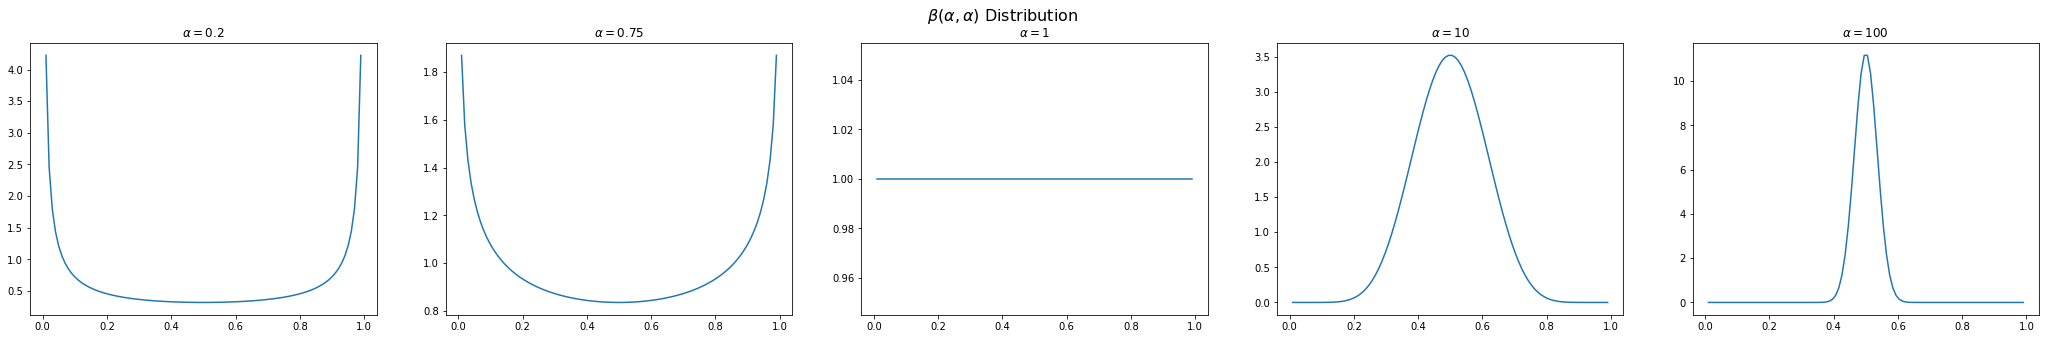

In [21]:
from scipy.stats import beta
x = np.linspace(0.01,0.99, 100)
fig, axes = plt.subplots(1,5,figsize=(36,5))
fig.suptitle(r"$\beta(\alpha,\alpha)$ Distribution",fontsize=16)
alphas = [0.2,0.75,1,10,100]
for a, ax in zip(alphas,axes.flatten()):
    ax.set_title(r"$\alpha={}$".format(a))
    ax.plot(x, beta.pdf(x, a, a))

In [4]:
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

#### Sharpening

$$Sharpen(p,T)_i := \dfrac{p_{i}^{1/T}}{\sum_{j=1}^{L}{p_{j}^{1/T}}}$$

The authors sharpen the model's predictions on the unlabeled data with the above equation as a form of entropy minimization. If the temperature $T < 1$, the effect is to make the predictions more certain, and as $T$ drops towards zero the predictions approach a one-hot distribution (see figure below). This relatively simple step, which involves no learned parameters, turns out to be incredibly important to the algorithm. In an ablation study, the paper reports an accuracy reduction of over 16% when removing the sharpening step (setting $T$ to $1$). 

The idea behind entropy minimization in semi-supervised learning is that the decision boundary of the classifier should not pass through high density regions of the data space. If this were the case, the boundary would split data that are very close together. In addition, small perturbations would result in large changes in predictions. As predictions near the decision boundary are more uncertain, entropy minimization seeks to make the model more confident in its predictions thus moving the boundary away from the data. While other approaches [3] add an entropy term to the loss, MixMatch directly lowers the entropy of the unlabeled targets via the equation above.  

As an example of this technique, let's try a classification problem that's simpler and easier to visualize than CIFAR -- MNIST. We'll still take 500 random examples as the labeled training set, and reserve the rest as the unlabeled set. The full images are used for training, but we'll also reduce each image to two dimensions using tSNE for visualization. Training in a semi-supervised manner following the same approach as MixMatch with regards to the unlabeled data, we'll use the model itself to generate pseudo-labels. The model consists of just two convolution layers and a linear head. No mixup or data augmentation is used, so we can isolate the effects of entropy minimization. The loss function is also largely the same as MixMatch, using cross-entropy for the labeled data and mean squared error for the unlabeled data, see the loss section below for the rationale behind this. The upper image is trained without using sharpening and in the lower image the pseduo-labels were sharpened with $T=0.5$. Training each for ten epochs, the unsharpened model has a test accuracy of 80.1%, and the sharpened model has an accuracy of 90.7%. In the images below, colors correspond to predicted class, and marker size is inversely proportional to prediction confidence (smaller markers are more confident). As shown by the marker sizes, the unsharpened model has a lot of uncertainty, especially around the edges of the clusters, while the sharpened model is much more confident in its predictions.

![No sharpening](images/sharpening_none.png "No sharpening")

![Sharpening](images/sharpening.png "Sharpening")*The effect of sharpening on the semi-supervised training of MNIST. Images in MNIST were reduced to two dimensions using tSNE. Colors correspond to predicted class, and marker size is inversely proportional to prediction confidence (smaller markers are more confident). The upper image was trained $T=1$, and the lower image with $T=0.5$.*

In [5]:
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

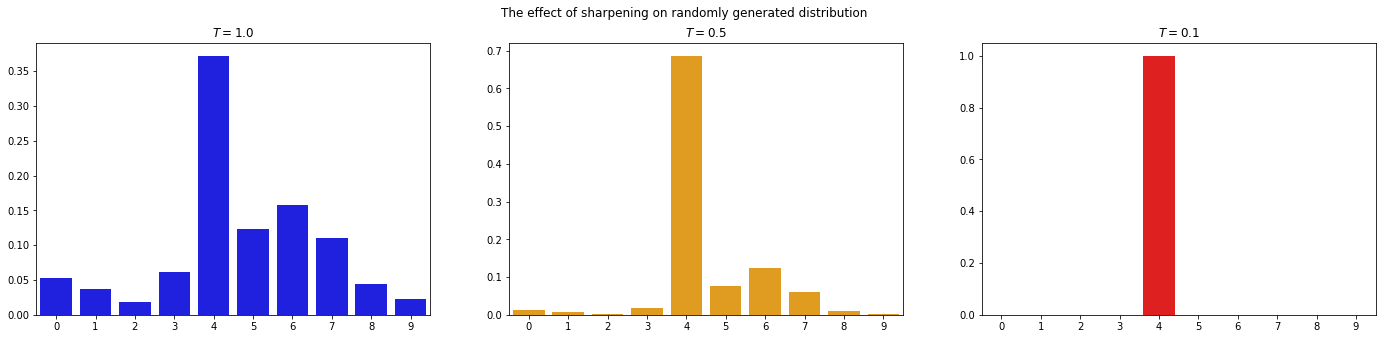

In [14]:
a = torch.softmax(torch.randn(10),0)
fig, axes = plt.subplots(1,3,figsize=(24,5))
fig.suptitle("The effect of sharpening on randomly generated distribution")
sns.barplot(x=np.arange(10),y=a,color="blue",ax=axes[0])
axes[0].set_title("$T = 1.0$")
sns.barplot(x=np.arange(10),y=sharpen(a[None,:],0.5)[0],color="orange",ax=axes[1])
axes[1].set_title("$T = 0.5$")
sns.barplot(x=np.arange(10),y=sharpen(a[None,:],0.1)[0],color="red",ax=axes[2])
axes[2].set_title("$T = 0.1$");

### The Mixmatch Algorithm

Now with all the pieces in place, the full algorithm can be implemented. Here are the steps for a single training iteration:

1. Supply a batch of labeled data with its labels, and a batch of unlabeled data
2. Augment the labeled batch to produce a new training batch. 
3. Augment each image in the unlabeled batch $K$ times, to produce a total of  $BatchSize * K$ new unlabeled examples.
4. For each original image in the unlabeled batch, pass the $K$ augmented versions to the model. Average the model's predictions across the augments to produce a single pseudo-label for the augmented images. 
5. Sharpen the pseudo-labels. 
6. The augmented labeled dataset and it's labels form set $X$. The augmented unlabeled data and it's (predicted) labels form set $U$.
7. Concatenate sets $U$ and $X$ into set $W$. Shuffle $W$. 
8. Form set $X'$ by applying mixup to sets $X$ and $|X|$ examples from $W$.
9. Form set $U'$ by applying mixup to sets $U$ and the examples in $W$ that were not used in step 8.

Sets $X'$ (labeled mixup) and $U'$ (unlabeled mixup) are then passed to the model, and the loss is computed using the corresponding mixed-up labels. 

### The Model

We will use a wideresnet model with 28 layers and a growth factor of 2 to match the paper. I use fastai's included WRN implementation.

In [6]:
model = models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32)

### Loss

With data and model in hand, we'll now implement the final piece requried for training -- the loss function. The loss function is the summation of two terms; the labeled and unlabeled losses. The labeled loss uses standard cross entropy, however the unlabeled loss function is the $l_2$ loss instead. This is because the $l_2$ loss is much less sensitive to very incorrect predicitions. Cross entropy loss is unbounded, and as the model's predicted probability of the correct class goes to zero cross entropy goes to infinty. However with $l_2$ loss, since we are working with probabilities, the worst case is that the model predicts 0 when the target is 1 or vice versa; this results in a loss of 1. With the unlabeled targets coming from the model itself, the algorithm doesn't want to penalize incorrect predictions too harshly. The parameter $\lambda$ (`l` in the code since lambda is reserved) controls the balance between the two terms.

We'll make one slight departure from the paper by linearly ramping up the weight of the unlabeled loss over the first 3000 iterations (roughly 10 epochs). Before applying this rampup, I was having difficulty training the model and found the accuracy would increase very slowly at in early epochs. Since the predicted labels at the start of training are essentially random, it makes sense to delay the application of unlabeled loss. By the time the weight of the unlabeled loss becomes significant, the model should be making reasonably good predictions. 

In [7]:
class MixupLoss(nn.Module):
    def forward(self, preds, target, unsort=None, ramp=None, bs=None):
        if unsort is None:
            return F.cross_entropy(preds,target)
        preds = preds[unsort]
        preds_l = preds[:bs]
        preds_ul = preds[bs:]
        preds_l = torch.log_softmax(preds_l,dim=1)
        preds_ul = torch.softmax(preds_ul,dim=1)
        loss_x = -(preds_l * target[:bs]).sum(dim=1).mean()
        loss_u = F.mse_loss(preds_ul,target[bs:])
        self.loss_x = loss_x.item()
        self.loss_u = loss_u.item()
        return loss_x + 100 * ramp * loss_u

### Training

Before training, lets review the hyperparemeters that have been introduced. 

| Hyperparameter | Description | Value |
| -------------- | ----------- | ----- |
| $K$            | Number of augments | 2 |
| $T$ | Sharpening Temperature | 0.5 |
| $\alpha$ | Beta dist. parameter | 0.75 |
| $\lambda$ | Unlabeled loss weight | 75 |

The authors of the paper claim that $T$ and $K$ should be relatively constant across most datasets, while $\alpha$ and $\lambda$ need to be tuned per set. We'll use the same hyperparameters as the paper's [official implementation](https://github.com/google-research/mixmatch). 

One implementation detail: the paper mentions that instead of learning rate annealing, it updates a second model with the exponentially moving average of the training model's parameters. This is yet another form of regularization, but is not essential to the algorithm. For those interested, there is code for training with an EMA model in the repository. However, I didn't find a significant benefit over learning rate scheduling, and in the name of simplicity we'll forgo EMA and use fastai's implementaion of the [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?) to schedule the learning and momentum rates. 

We'll use fastai's callback system to write a method which handles most of the MixMatch steps. This method takes in batches from the labeled and unlabeled sets, gets the predicted labels, and then performs mixup. 

In [8]:
class MixMatchTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.smoothL, self.smoothUL = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["l_loss","ul_loss"])
        self.it = 0
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        try:
            x_l,y_l = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            x_l,y_l = next(self.l_dl)
            
        x_ul = last_input
        
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul[:,i]) for i in range(x_ul.shape[1])],dim=1),dim=2).mean(dim=1))
            
        x_ul = torch.cat([x for x in x_ul])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])
        
        l_labels = torch.eye(data_labeled.c).cuda()[y_l]
        
        w_x = torch.cat([x_l,x_ul])
        w_y = torch.cat([l_labels,ul_labels])
        idxs = torch.randperm(w_x.shape[0])
        
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        bn_idxs = torch.randperm(mixed_input.shape[0])
        unsort = [0] * len(bn_idxs)
        for i,j in enumerate(bn_idxs): unsort[j] = i
        mixed_input = mixed_input[bn_idxs]
    

        ramp = self.it / 3000.0 if self.it < 3000 else 1.0
        return {"last_input": mixed_input, "last_target": (mixed_target,unsort,ramp,x_l.shape[0])}
    
    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothL.add_value(self.learn.loss_func.loss_x)
        self.smoothUL.add_value(self.learn.loss_func.loss_u)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothL.smooth,self.smoothUL.smooth])    

A fastai `Learner` object contains the dataloaders and the model, and is responsible for executing the training loop. It also has a lot of utility functions, such as learning rate finding and prediction interpretation. An epoch in this implementation is one pass through the entire unlabeled dataset.

In [9]:
learn = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)

### Results

For reference, I ran these tests on a Google Compute Engine virtual machine with 16 CPUs and a single P100 GPU. The first step is to establish some baselines so that MixMatch's performance can be compared. First, I'll try the fully supervised case with all 50k training images.

In [10]:
learnFS = Learner(data_full,models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32),metrics=accuracy)
learnFS.fit_one_cycle(100,2e-2,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.191859,1.232437,0.570300,01:53
1,0.923196,0.926058,0.676400,01:54
2,0.764989,0.983374,0.688000,01:54
3,0.684145,0.792043,0.742400,01:54
4,0.637452,0.706040,0.763000,01:54
5,0.579363,0.792375,0.738900,01:54
6,0.560745,0.761193,0.748400,01:55
7,0.542322,0.623887,0.793000,01:54
8,0.505341,0.625939,0.797400,01:53
9,0.478072,0.605989,0.810400,01:53


Next I will try training on just the 500 labeled images, with no unsupervised component.

In [ ]:
learnBase = Learner(data_labeled,models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32),metrics=accuracy)
learnBase.fit_one_cycle(50,2e-2,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.211227,2.303742,0.100000,00:08
1,2.136889,2.358332,0.100000,00:08
2,2.065619,3.168624,0.100500,00:08
3,2.010923,2.863336,0.215300,00:08
4,1.961602,48.241714,0.107600,00:08
5,1.931448,7.775838,0.187700,00:08
6,1.920944,57.763363,0.102900,00:08
7,1.911295,6.584240,0.154000,00:08
8,1.898177,91.394135,0.106300,00:08
9,1.898196,5.922698,0.213500,00:08


Finally I will train with MixMatch, using the learner defined in the previous section. Note that I now use `learn.fit` instead of `learn.fit_one_cycle` since MixMatch uses EMA instead of a learning rate schedule. 

In [ ]:
learn.fit_one_cycle(200,2e-3,wd=0.02)

epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.768446,1.692881,0.389600,1.677018,0.008062,04:27
1,1.623252,1.635129,0.432200,1.342663,0.011633,04:34
2,1.591076,1.659631,0.442200,1.164911,0.011560,04:33
3,1.707859,1.626472,0.472800,1.100260,0.012204,04:34
4,1.748360,1.692946,0.469300,1.037391,0.011352,04:35
5,1.981373,1.682426,0.481600,1.089962,0.011801,04:35
6,2.238199,1.659572,0.494100,1.103848,0.012825,04:35
7,2.401606,1.676859,0.486100,1.113788,0.012912,04:34
8,2.275591,1.773682,0.486400,1.061513,0.012141,04:29
9,2.122196,1.780571,0.522700,0.980808,0.011414,04:35


Note: Training stopped at 186 epochs due to vm preemption.

### Conclusion

MixMatch clearly boasts impressive performance, but the downside is the additional time cost in training. Compared to the fully supervised case, training MixMatch takes approximately 2.5x longer. Some of this may be due to inefficiencies in the implementation, but generating multiple augmentations and then obtaining model predictions for labels has a significant cost, especially in the one GPU case. I trained the offical Tensorflow implemention for comparison, and verified that MixMatch takes a long time to fully converge; over twelve hours of training resulted in an error rate several percent higher than the one reported in the paper. It would take nearly two days of training on the P100 setup to match their results fully. However, a few hours of training will achieve the vast majority of accuracy improvement, with the final few percent taking most of the total training time.   

While augmentation and sharpening are hugely beneficial, the paper's ablation study shows that the single most important component, error wise, is MixUp. This is also the most mysterious component in terms of why it works so well -- why should enforcing linearity in predictions between images help the model? Certainly it reduces memorization of training data, but so does data augmentation and to not nearly the same effect in this case. Even the original MixUp paper only provides informal arguments as to its efficacy; from that paper:

> "We argue that this linear behaviour reduces the amount of undesirable oscillations when predicting outside the
training examples. Also, linearity is a good inductive bias from the perspective of Occam’s razor, since it is one of the simplest possible behaviors" [4]

Other researches have expanded upon the idea; for example by mixing up intermediate states instead of the input [7], or using a neural network instead of the beta function to generate the mixup coefficient [6]. However, I am unable to find a solid theoretical justification; this is yet another technique that falls into the 'it just works' category. Certainly it would be difficult to draw a biological analogy -- humans hardly learn a concept by blending it with an unrelated concept. 

That said, MixMatch is hugely promising and it will be interesting to see it applied to other domains beyond vision. 


### References
[1]: Berthelot, David, Nicholas Carlini, Ian Goodfellow, Nicolas Papernot, Avital Oliver, and Colin Raffel. “MixMatch: A Holistic Approach to Semi-Supervised Learning.” ArXiv:1905.02249 [Cs, Stat], May 6, 2019. http://arxiv.org/abs/1905.02249.

[2]: Tarvainen, Antti, and Harri Valpola. “Mean Teachers Are Better Role Models: Weight-Averaged Consistency Targets Improve Semi-Supervised Deep Learning Results.” ArXiv:1703.01780 [Cs, Stat], March 6, 2017. http://arxiv.org/abs/1703.01780.

[3]: Miyato, Takeru, Shin-ichi Maeda, Masanori Koyama, and Shin Ishii. “Virtual Adversarial Training: A Regularization Method for Supervised and Semi-Supervised Learning.” ArXiv:1704.03976 [Cs, Stat], April 12, 2017. http://arxiv.org/abs/1704.03976.

[4]: Zhang, Hongyi, Moustapha Cisse, Yann N. Dauphin, and David Lopez-Paz. “Mixup: Beyond Empirical Risk Minimization.” ArXiv:1710.09412 [Cs, Stat], October 25, 2017. http://arxiv.org/abs/1710.09412.

[5]: Polyak, Boris, and Anatoli Juditsky. “Acceleration of Stochastic Approximation by Averaging.” SIAM Journal on Control and Optimization 30 (July 1, 1992): 838–55. https://doi.org/10.1137/0330046.

[6]: Guo, Hongyu, Yongyi Mao, and Richong Zhang. “MixUp as Locally Linear Out-Of-Manifold Regularization,” n.d., 9.

[7]: Verma, Vikas, Alex Lamb, Christopher Beckham, Amir Najafi, Ioannis Mitliagkas, Aaron Courville, David Lopez-Paz, and Yoshua Bengio. “Manifold Mixup: Better Representations by Interpolating Hidden States,” June 13, 2018. https://arxiv.org/abs/1806.05236v7.